# Predict Future Sales

## Problem Definition

* **Definition**: Understanding the project objectives and requirements from a domain perspective
* The task is to forecast the total amount of products sold in every shop for the test set, given daily historical sales data. 
  * Note that the list of shops and products slightly changes every month. 
  * Creating a robust model that can handle such situations is part of the challenge.

## Data Preparation

* **Definition**: constructing a dataset from one or more data sources to be used for exploration and modeling
* **Input Data:**
  * **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
    * **Numerical Variables:** date, item_price, item_cnt_day
    * **Categorical Variables:** date_block_num, shop_id, item_id
  * **test.csv** - the test set. 
    * **Numerical Variables:** date, item_price, item_cnt_day
    * **Categorical Variables:** ID, shop_id, item_id
  * **items.csv** - supplemental information about the items/products.
    * **Categorical Variables:** item_name, item_id, item_category_id
  * **item_categories.csv** - supplemental information about the items categories.
    * **Categorical Variables:** item_category_name, item_category_id
  * **shops.csv**- supplemental information about the shops.
    * **Categorical Variables:** shop_name, shop_id
* **Output Data:**
  * **submission.csv** - predicted item_cnt_month
    * **Numerical Variables:** item_cnt_month
    * **Categorical Variables:** ID

In [59]:
# Install Libraries
install.packages("gbm")
install.packages("tictoc")
install.packages("randomForest")
install.packages("scales")
install.packages("skimr")

# Import Libraries
library(skimr)
library(tidyr)
library(scales)
library(dplyr)
library(ggplot2)
library(lubridate)
library(caret)
library(e1071)
library(gbm)
library(data.table)
library(tictoc)

# list.files(path = "../input") # Helpful for finding relevant data files
# Load in the data
tic("Data Loading ")
sales_data = fread("../input/sales_train.csv")
item_data = fread("../input/items.csv")
test_data = fread("../input/test.csv")
toc()

glimpse(sales_data)
glimpse(item_data)
glimpse(test_data)
skim(sales_data)

Warning message:
"package 'gbm' is in use and will not be installed"Warning message:
"package 'tictoc' is in use and will not be installed"Warning message:
"package 'randomForest' is in use and will not be installed"Warning message:
"package 'scales' is in use and will not be installed"Warning message:
"package 'skimr' is in use and will not be installed"

Data Loading : 0.52 sec elapsed
Rows: 2,935,849
Columns: 6
$ date           <chr> "02.01.2013", "03.01.2013", "05.01.2013", "06.01.201...
$ date_block_num <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ shop_id        <int> 59, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, ...
$ item_id        <int> 22154, 2552, 2552, 2554, 2555, 2564, 2565, 2572, 257...
$ item_price     <dbl> 999.00, 899.00, 899.00, 1709.05, 1099.00, 349.00, 54...
$ item_cnt_day   <dbl> 1, 1, -1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2, 1, 2, 1, ...
Rows: 22,170
Columns: 3
$ item_name        <chr> "! Ð’Ðž Ð’Ð›Ð\220Ð¡Ð¢Ð\230 Ð\235Ð\220Ð’Ð\220Ð–Ð”Ð•...
$ item_id          <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ...
$ item_category_id <int> 40, 76, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 55...
Rows: 214,200
Columns: 3
$ ID      <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1...
$ shop_id <int> 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...
$ item_id <int> 5037, 5

### Aggregate/Clean Input Data

* For better subsequent analysis it is a good idea to merge the sales data with information regarding year, month, and the day of the week.
* Need to remove outlier sales data (item_price > 100000 and item_cnt_day > 1000)
* Need to remove rows where a data value is NA

In [44]:
sales_data = merge(sales_data, item_data[,c("item_id", "item_category_id")], by = "item_id", all.x = T)
sales_data$date = as.Date(sales_data$date, "%d.%m.%Y")

sales_data$year = year(sales_data$date)
sales_data$year =  as.factor(sales_data$year)

sales_data$month = month(sales_data$date)
sales_data$month = as.factor(sales_data$month)

sales_data$day = day(sales_data$date)
sales_data$day = as.factor(sales_data$day)

sales_data$weekdays =  weekdays(sales_data$date)
sales_data$weekdays = as.factor(sales_data$weekdays)

sales_data$item_category_id =  as.factor(sales_data$item_category_id)

# Remove Outliers and Invalid Data (negative or NA)
sales_data = sales_data[sales_data$item_price<= 100000,]
sales_data = sales_data[sales_data$item_cnt_day<= 1000,]

sales_data <- sales_data %>%
  mutate( item_cnt_day = ifelse(item_cnt_day < 0, 0, item_cnt_day),
          item_price = ifelse(is.na(item_price), 0, item_price))

## Data Exploration

* **Definition**: Describing the data by means of statistical and visualization techniques

### Univariate Visualization

#### Yearly Revenue

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

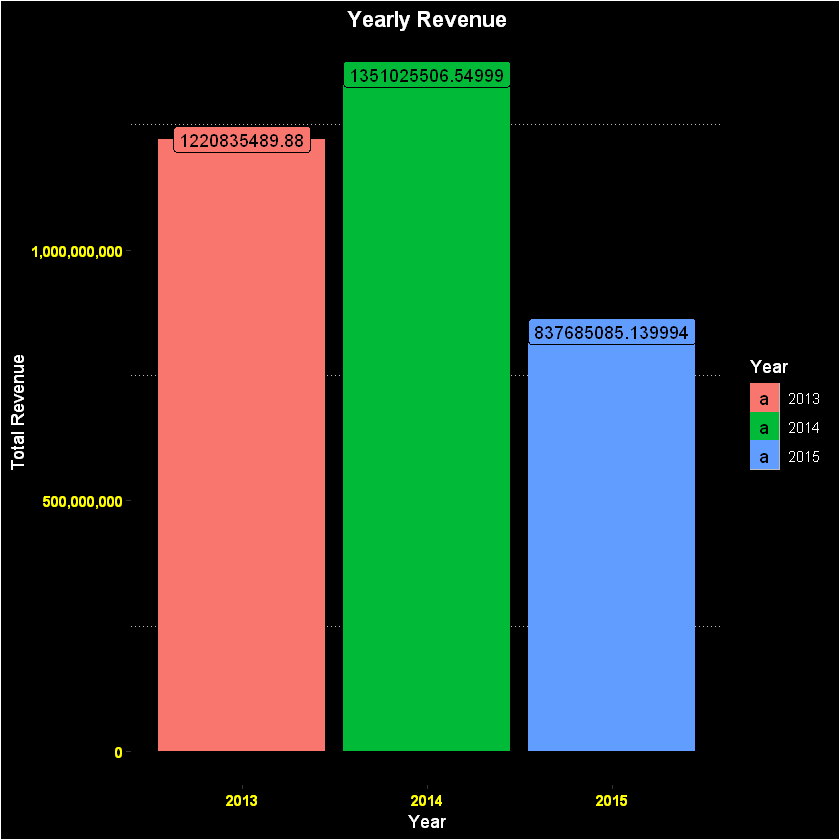

In [45]:
yearly_sales = sales_data %>%
  group_by(year) %>%
  summarise(yearly_sale = sum(item_price * item_cnt_day))

ggplot(yearly_sales, aes(x =  year, y = yearly_sale, fill =  factor(year))) +
  geom_histogram(stat = "identity") +
  labs(title = "Yearly Revenue",
       x = "Year",
       y = "Total Revenue",
       fill = "Year") +
  geom_label(
    stat = "identity",
    position = position_dodge(width = 1),
    hjust = "center",
    aes(label = yearly_sale)
  ) +
  theme(
    # Remove panel grid
    panel.grid.major = element_blank(),
    panel.grid.minor = element_line(colour = "gray", linetype = "dotted"),
    # Change plot and panel background
    plot.background = element_rect(fill = "black"),
    panel.background = element_rect(fill = 'black'),
    # Change legend
    # legend.position = "none",
    legend.background = element_rect(fill = "black", color = NA),
    legend.key = element_rect(color = "gray", fill = "black"),
    legend.title = element_text(color = "white"),
    legend.text = element_text(color = "white"),
    # Align title to top center
    plot.title = element_text(
      color = "white",
      hjust = 0.5,
      face = "bold"
    ),
    # Change axis ticks to bold black
    axis.text = element_text(colour = "yellow", face = "bold"),
    axis.title.x = element_text(color = "white"),
    axis.title.y = element_text(color = "white")
  ) + scale_y_continuous(labels = comma)

#### Revenue Per Day of the Week (Bar Chart)

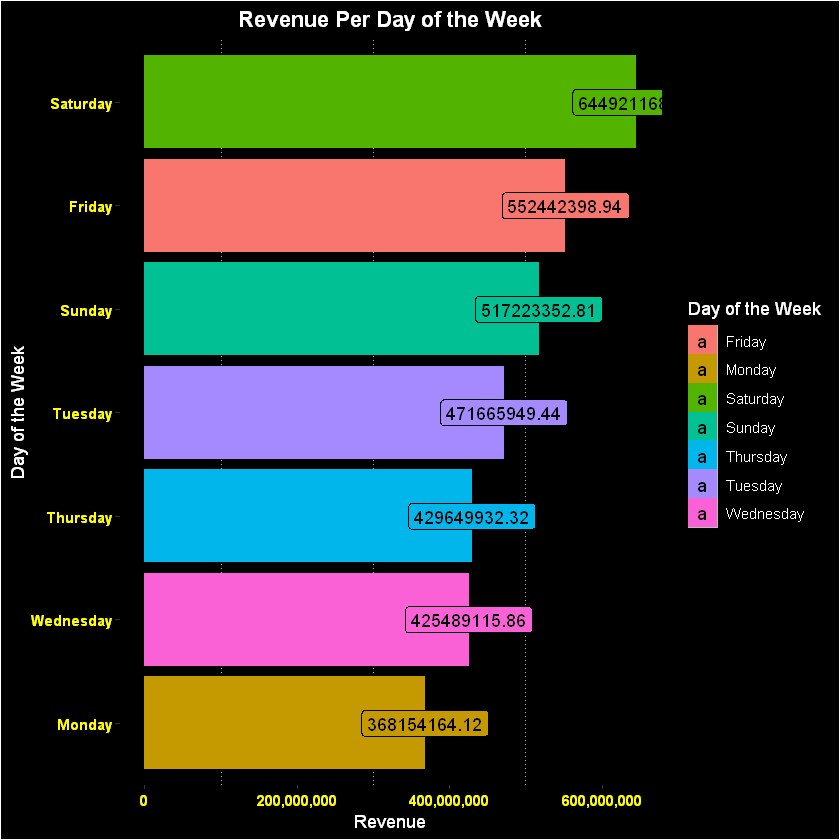

In [46]:
weekdays_sales = sales_data %>%
  group_by(weekdays) %>%
  summarise(total_sale = sum(item_cnt_day * item_price)) %>%
  arrange(desc(total_sale))
weekdays_sales$total_sale = round(weekdays_sales$total_sale, 2)

ggplot(weekdays_sales, aes(
  x = reorder(weekdays, total_sale),
  y =  total_sale,
  fill = factor(weekdays)
)) +
  geom_bar(stat = "identity") +
  labs(title = "Revenue Per Day of the Week",
       x = "Day of the Week",
       y =  "Revenue",
       fill = "Day of the Week") +
  coord_flip() +
  geom_label(
    stat = "identity",
    position = position_dodge(width = 1),
    hjust = "center",
    aes(label = total_sale)
  ) +
  theme(
    # Remove panel grid
    panel.grid.major = element_blank(),
    panel.grid.minor = element_line(colour = "gray", linetype = "dotted"),
    # Change plot and panel background
    plot.background = element_rect(fill = "black"),
    panel.background = element_rect(fill = 'black'),
    # Change legend
    # legend.position = "none",
    legend.background = element_rect(fill = "black", color = NA),
    legend.key = element_rect(color = "gray", fill = "black"),
    legend.title = element_text(color = "white"),
    legend.text = element_text(color = "white"),
    # Align title to top center
    plot.title = element_text(
      color = "white",
      hjust = 0.5,
      face = "bold"
    ),
    # Change axis ticks to bold black
    axis.text = element_text(colour = "yellow", face = "bold"),
    axis.title.x = element_text(color = "white"),
    axis.title.y = element_text(color = "white")
  ) + scale_y_continuous(labels = comma)

#### Number of Sales Per Shop (Bar Chart)

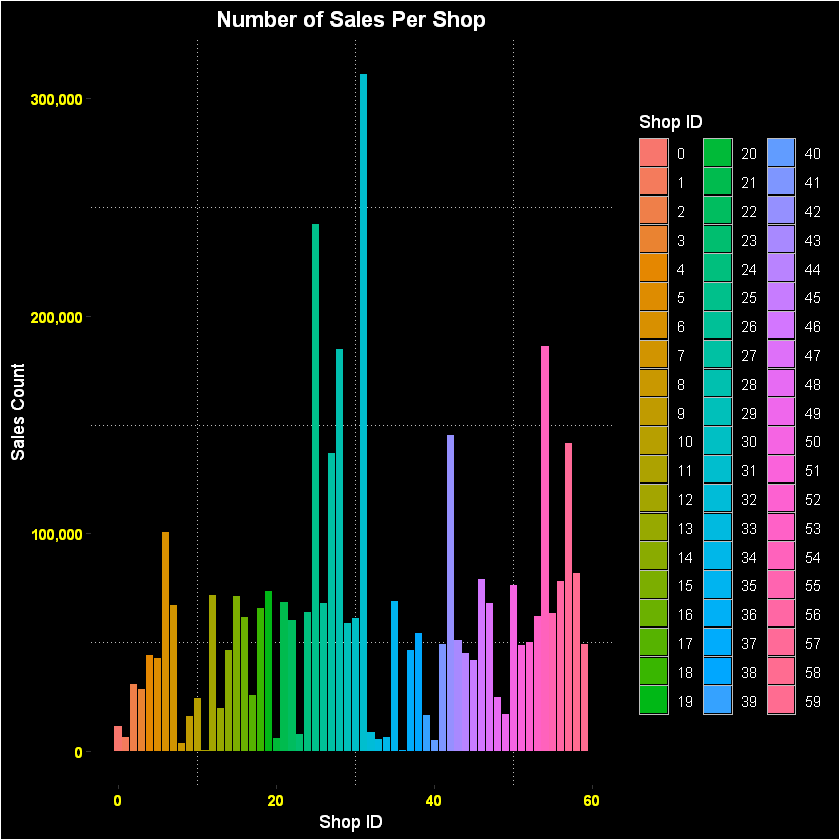

In [47]:
sales_shopwise = sales_data %>%
  select(shop_id, item_cnt_day) %>%
  group_by(shop_id) %>%
  summarise(item_cnt_day =  sum(item_cnt_day, na.rm = T))

ggplot(data =  sales_shopwise,
       mapping = aes(
         x = shop_id,
         y = item_cnt_day,
         fill = factor(shop_id)
       )) +
  geom_bar(stat = "identity") +
  xlab("Shop ID") + ylab("Sales Count") +
  ggtitle(label = "Number of Sales Per Shop") +
  theme(
    # Remove panel grid
    panel.grid.major = element_blank(),
    panel.grid.minor = element_line(colour = "gray", linetype = "dotted"),
    # Change plot and panel background
    plot.background = element_rect(fill = "black"),
    panel.background = element_rect(fill = 'black'),
    # Change legend
    # legend.position = "none",
    legend.background = element_rect(fill = "black", color = NA),
    legend.key = element_rect(color = "gray", fill = "black"),
    legend.title = element_text(color = "white"),
    legend.text = element_text(color = "white"),
    # Align title to top center
    plot.title = element_text(
      color = "white",
      hjust = 0.5,
      face = "bold"
    ),
    # Change axis ticks to bold black
    axis.text = element_text(colour = "yellow", face = "bold"),
    axis.title.x = element_text(color = "white"),
    axis.title.y = element_text(color = "white"),
  ) + scale_y_continuous(labels = comma) + scale_fill_discrete(name = "Shop ID")

#### Most Popular Item Per Shop (Bar Chart)

`summarise()` has grouped output by 'shop_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'shop_id'. You can override using the `.groups` argument.


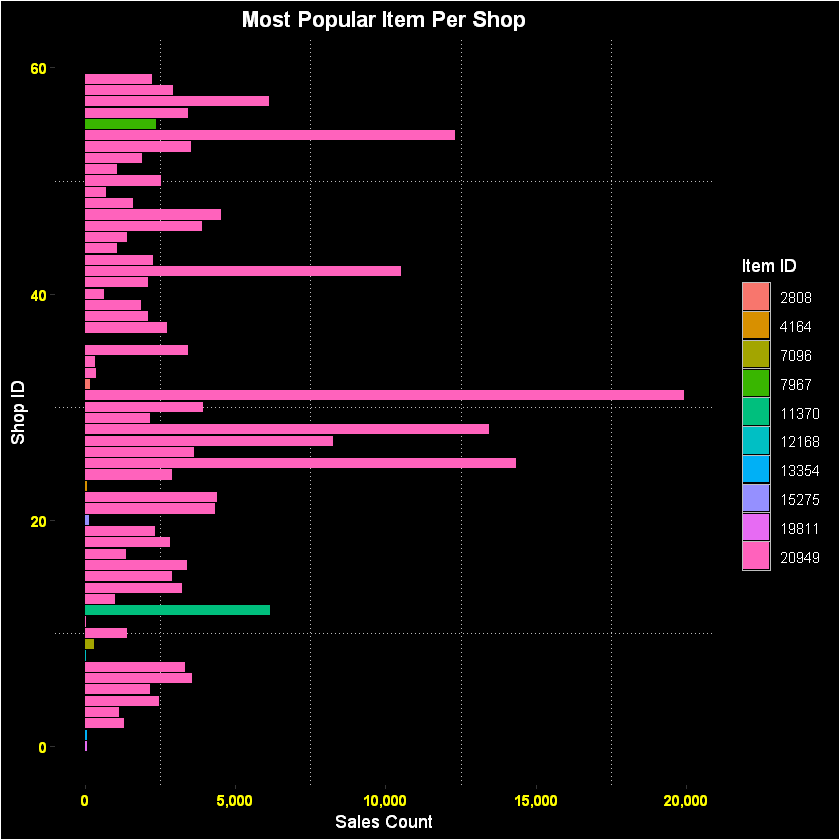

In [48]:
popularity  =  sales_data %>%
  group_by(shop_id, item_id) %>%
  summarise(sold_item_count = sum(item_cnt_day)) %>%
  arrange(desc(sold_item_count))

popular_items_in_shop  =  sales_data %>%
  group_by(shop_id, item_id) %>%
  summarise(sold_item_count = sum(item_cnt_day)) %>%
  filter(sold_item_count == max(sold_item_count)) %>%
  arrange(desc(sold_item_count))

ggplot(data = popular_items_in_shop,
       mapping = aes(
         x = shop_id,
         y = sold_item_count,
         fill = factor(item_id)
       )) +
  geom_bar(stat = "identity") +
  xlab("Shop ID") + ylab("Sales Count") +
  ggtitle("Most Popular Item Per Shop") +
  coord_flip() +
  theme(
    # Remove panel grid
    panel.grid.major = element_blank(),
    panel.grid.minor = element_line(colour = "gray", linetype = "dotted"),
    # Change plot and panel background
    plot.background = element_rect(fill = "black"),
    panel.background = element_rect(fill = 'black'),
    # Change legend
    # legend.position = "none",
    legend.background = element_rect(fill = "black", color = NA),
    legend.key = element_rect(color = "gray", fill = "black"),
    legend.title = element_text(color = "white"),
    legend.text = element_text(color = "white"),
    # Align title to top center
    plot.title = element_text(
      color = "white",
      hjust = 0.5,
      face = "bold"
    ),
    # Change axis ticks to bold black
    axis.text = element_text(colour = "yellow", face = "bold"),
    axis.title.x = element_text(color = "white"),
    axis.title.y = element_text(color = "white")
  ) + scale_y_continuous(labels = comma) + scale_fill_discrete(name = "Item ID")

### Bivariate Visualization

#### Daily Item Sales from January 2013 to October 2015(Scatter Plot)

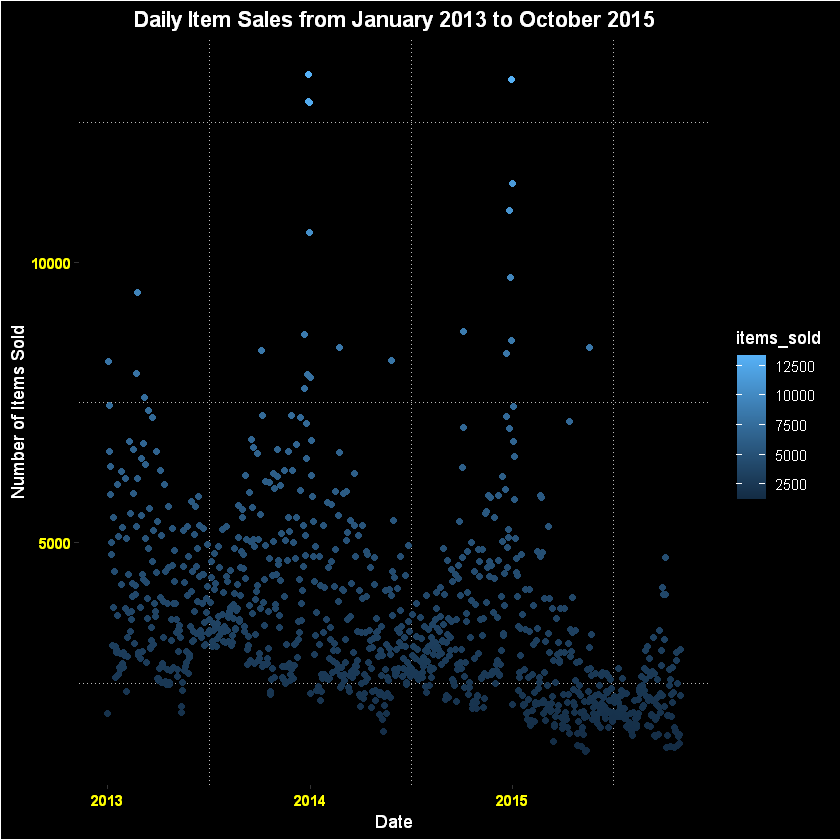

In [49]:
daily_sale = sales_data %>%
  group_by(date) %>%
  summarise(items_sold =  sum(item_cnt_day))

ggplot(daily_sale, aes(x =  date, y = items_sold, color =  items_sold)) +
  # geom_line() +
  geom_point() +
  labs(title = "Daily Item Sales from January 2013 to October 2015", x =  "Date", y = "Number of Items Sold") +
  theme(
    # Remove panel grid
    panel.grid.major = element_blank(),
    panel.grid.minor = element_line(colour = "gray", linetype = "dotted"),
    # Change plot and panel background
    plot.background = element_rect(fill = "black"),
    panel.background = element_rect(fill = 'black'),
    # Change legend
    # legend.position = "none",
    legend.background = element_rect(fill = "black", color = NA),
    legend.key = element_rect(color = "gray", fill = "black"),
    legend.title = element_text(color = "white"),
    legend.text = element_text(color = "white"),
    # Align title to top center
    plot.title = element_text(
      color = "white",
      hjust = 0.5,
      face = "bold"
    ),
    # Change axis ticks to bold black
    axis.text = element_text(colour = "yellow", face = "bold"),
    axis.title.x = element_text(color = "white"),
    axis.title.y = element_text(color = "white")
  ) + scale_fill_discrete(name = "Number of Items Sold")

#### Yearly-Monthly Sales (Stacked Bar Chart)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.
Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

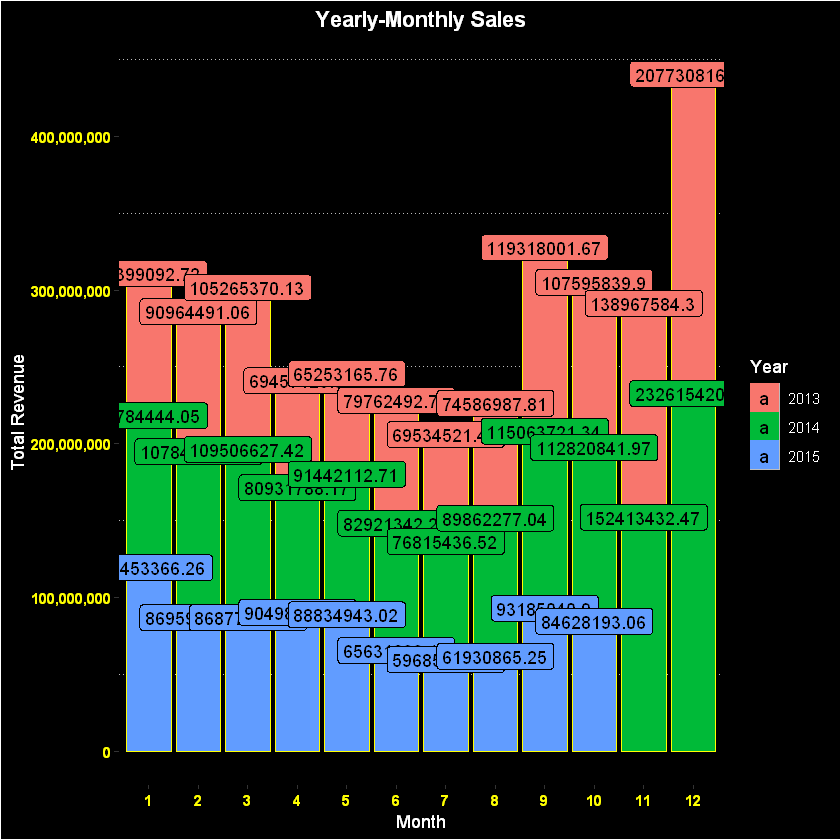

In [50]:
ym_sales = sales_data %>%
  group_by(year, month) %>%
  summarise(ym_sale = sum(item_price * item_cnt_day)) %>%
  arrange(year)

ym_sales$ym_sale = round(ym_sales$ym_sale, 2)
ggplot(ym_sales, aes(x =  month, y = ym_sale, fill =  factor(year))) +
  geom_histogram(stat = "identity", color = "yellow") +
  labs(title = "Yearly-Monthly Sales",
       x = "Month",
       y =  "Total Revenue",
       fill = "Year") +
  geom_label(
    stat = "identity",
    position = position_stack(),
    hjust = "center",
    vjust = 0.5,
    aes(label = ym_sale)
  ) +
  theme(
    # Remove panel grid
    panel.grid.major = element_blank(),
    panel.grid.minor = element_line(colour = "gray", linetype = "dotted"),
    # Change plot and panel background
    plot.background = element_rect(fill = "black"),
    panel.background = element_rect(fill = 'black'),
    # Change legend
    # legend.position = "none",
    legend.background = element_rect(fill = "black", color = NA),
    legend.key = element_rect(color = "gray", fill = "black"),
    legend.title = element_text(color = "white"),
    legend.text = element_text(color = "white"),
    # Align title to top center
    plot.title = element_text(
      color = "white",
      hjust = 0.5,
      face = "bold"
    ),
    # Change axis ticks to bold black
    axis.text = element_text(colour = "yellow", face = "bold"),
    axis.title.x = element_text(color = "white"),
    axis.title.y = element_text(color = "white")
  ) + scale_y_continuous(labels = comma)

## Predictive Modeling

* **Definition**: the process by which a model is created to predict an outcome

### Linear Regression Model (MLR)

* Multiple linear regression (MLR), also known simply as multiple regression, is a statistical technique that uses several explanatory variables to predict the outcome of a response variable. 

In [53]:
tic("Time Taken to Run Linear Regression Model ")
linear_model = lm(formula = item_cnt_day ~ shop_id + item_id, data = sales_data)
toc()

summary(linear_model)


Call:
lm(formula = item_cnt_day ~ shop_id + item_id, data = sales_data)

Residuals:
   Min     1Q Median     3Q    Max 
 -1.35  -0.28  -0.23  -0.20 998.66 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.203e+00  3.673e-03  327.61   <2e-16 ***
shop_id     -8.714e-04  8.242e-05  -10.57   <2e-16 ***
item_id      6.861e-06  2.115e-07   32.45   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.29 on 2935844 degrees of freedom
Multiple R-squared:  0.00039,	Adjusted R-squared:  0.0003893 
F-statistic: 572.7 on 2 and 2935844 DF,  p-value: < 2.2e-16


### Gradient Boosting Machine (GBM) Model

* A Gradient Boosting Machine or GBM combines the predictions from multiple decision trees to generate the final predictions. 

In [56]:
tic("Time Taken to Run GBM Model ")
gbm_model  =  gbm(
  formula = item_cnt_day ~ shop_id + item_id,
  data = sales_data,
  shrinkage = 0.01,
  distribution = "gaussian",
  n.trees = 1000,
  interaction.depth = 5,
  bag.fraction = 0.5,
  train.fraction = 0.8,
  cv.folds = 5,
  n.cores = 1,
  verbose = T
)
toc()

CV: 1 
CV: 2 
CV: 3 
CV: 4 
CV: 5 
Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        4.0137         10.1901     0.0100    0.0011
     2        4.0127         10.1902     0.0100    0.0010
     3        4.0117         10.1903     0.0100    0.0008
     4        4.0110         10.1904     0.0100    0.0008
     5        4.0100         10.1905     0.0100    0.0008
     6        4.0089         10.1906     0.0100    0.0009
     7        4.0080         10.1907     0.0100    0.0007
     8        4.0071         10.1909     0.0100    0.0008
     9        4.0061         10.1910     0.0100    0.0009
    10        4.0051         10.1911     0.0100    0.0005

Time Taken to Run GBM Model : 40.04 sec elapsed


## Model Evaluation

Definition: Methods to find the best model that represents the data and how well the chosen model will work in the future

Metric Used: Root Mean Square Error (RMSE)

In [57]:
#RMSE - LM
RSS <- c(crossprod(linear_model$residuals)) # Residual Sum of Squares
MSE <- RSS / length(linear_model$residuals) # Mean Squared Error
RMSE_lm <- sqrt(MSE)

#RMSE - GBM
best <- which.min(gbm_model$cv.error)
RMSE_gbm <- sqrt(gbm_model$cv.error[best])

RMSE_lm
RMSE_gbm

[1] 2.290474

[1] 2.001805

## Prediction and Submission

* Since the RMSE for the GBM model, that will be used to make the final prediction for forecasting sales data

In [58]:
result_gbm = predict(gbm_model, test_data[, c("shop_id", "item_id")], n.trees = 1000)

sub = data.frame(ID = test_data$ID, item_cnt_month =  result_gbm)
write.csv(sub, "submission.csv", row.names = F)

Warning message in predict.gbm(gbm_model, test_data[, c("shop_id", "item_id")], :
"Number of trees not specified or exceeded number fit so far. Using 10."